In [41]:
# Load basic packages
import numpy as np
import pandas as pd

import autograd.numpy as numpy
import autograd.numpy.random as npr

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn import model_selection

# Useful for saving our models.
import pickle
print("Imported all!")

Imported all!


In [42]:
df = pd.read_csv('diabetes.csv')
df = df.dropna()
diabetes = df.values
print("Shape of the loaded dataset: {} rows and {} columns.".format(diabetes.shape[0], diabetes.shape[1]))


Shape of the loaded dataset: 253680 rows and 22 columns.


# Let's plot all the distributions we care about

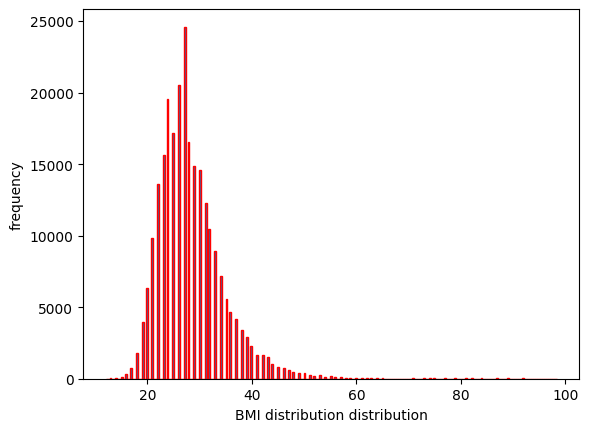

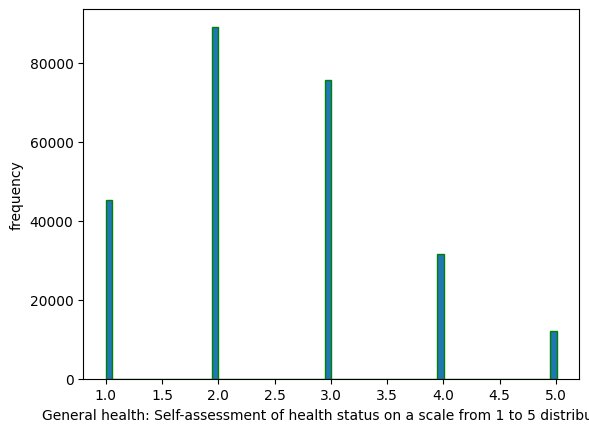

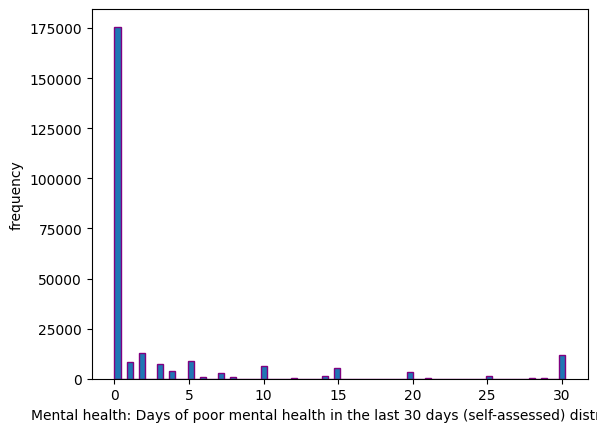

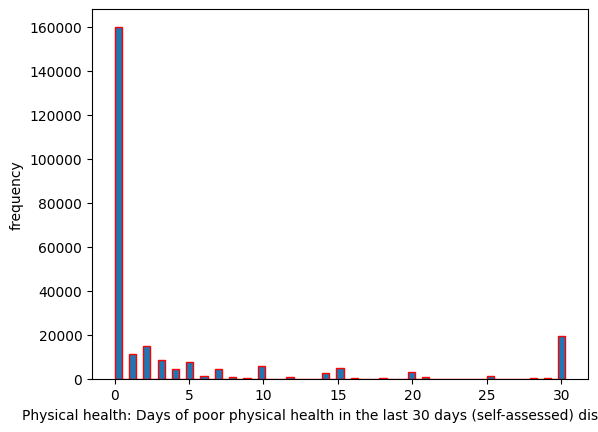

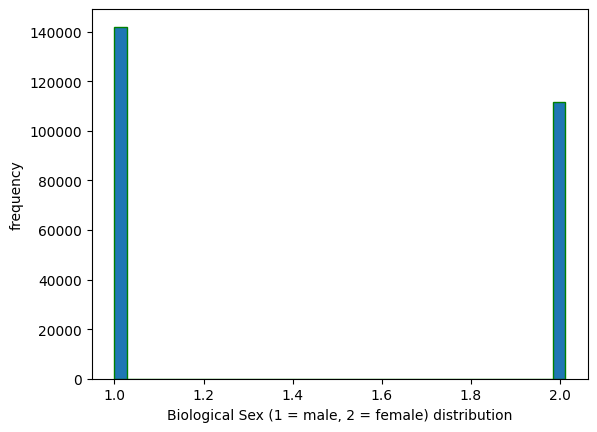

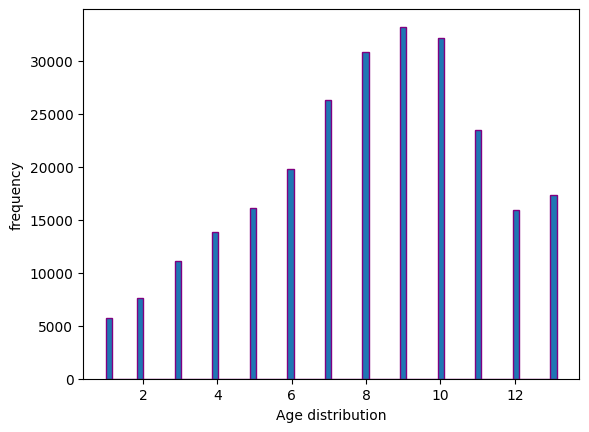

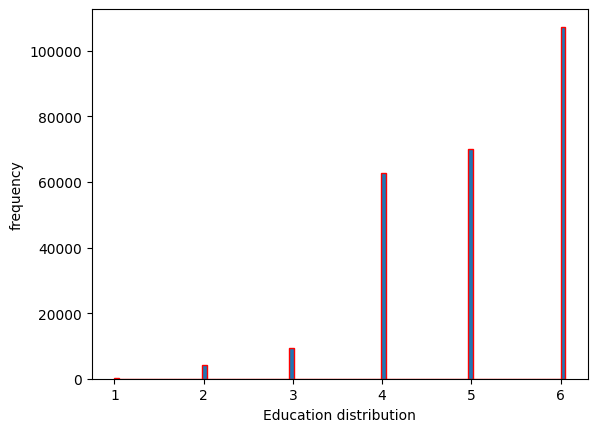

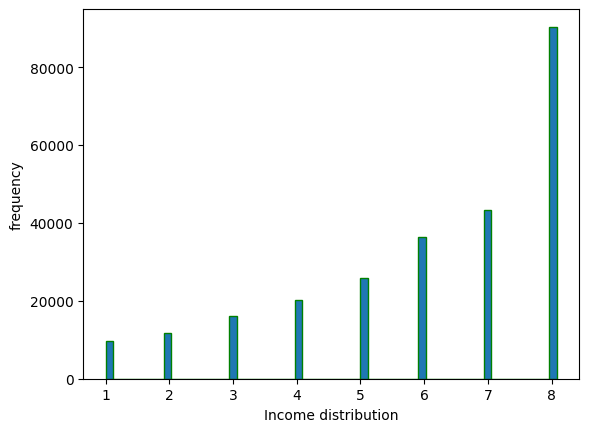

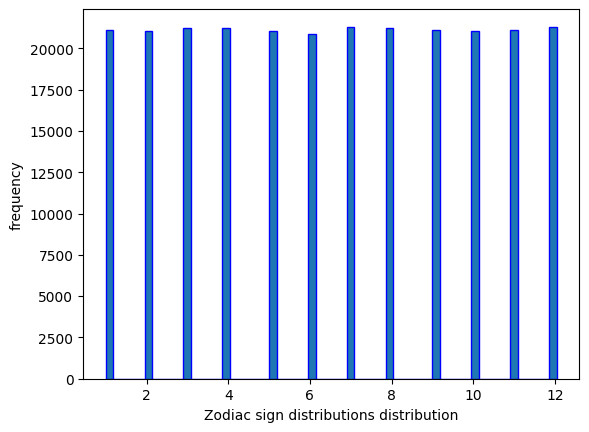

In [43]:
def plot_freq_dist(predictor_col, color: str = "red", title = "N/A"):
    """
    data: 1d dataframe to plot on the graph
    """
    data = predictor_col
    data_size = data.shape[0]
    # Let's use the Scott's rule for choosing the right bin width
    w = 3.49 * np.std(data)/data_size**(1./3)

    # define number of bins with accordance to the appropriate size 
    bins = np.arange(data.min().item(), data.max().item() + w, w, dtype=float)

    plt.hist(data, edgecolor=color, bins=bins) 
    plt.xlabel("{} distribution".format(title))  # Set x-axis label
    plt.ylabel("frequency")     # Set y-axis label
    plt.show()  # Show the plot

# let's plot continious variables
plot_freq_dist(diabetes[:, 3], color="red", title="BMI distribution")
plot_freq_dist(diabetes[:, 13], color="green", title="General health: Self-assessment of health status on a scale from 1 to 5")
plot_freq_dist(diabetes[:, 14], color="purple", title="Mental health: Days of poor mental health in the last 30 days (self-assessed)")
plot_freq_dist(diabetes[:, 15], color="red", title="Physical health: Days of poor physical health in the last 30 days (self-assessed)")
plot_freq_dist(diabetes[:, 17], color="green", title="Biological Sex (1 = male, 2 = female)")

# bracketed ordinal variables
plot_freq_dist(diabetes[:, 18], color="purple", title="Age")
plot_freq_dist(diabetes[:, 19], color="red", title="Education")
plot_freq_dist(diabetes[:, 20], color="green", title="Income")

# zodiac sign
plot_freq_dist(diabetes[:, 21], color="blue", title="Zodiac sign distributions")

# Zodiac sign distribution is very close to uniform distribution. Therefore, let's not take that predictor into account

In [44]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Sample data
data = diabetes

# Define columns
categorical_cols = [17, 21]  # Indices of categorical columns (sex + zodiac sign)
# We are not going to touch the ordinal data anyhow, since it is already giving the appropriate weights to the model
# ordinal_cols = [18, 19, 20]  # Indices of ordinal columns (age, education, income)
continuous_cols = [3, 13, 14, 15]  # Indices of continuous columns (BMI, general health, mental health, physical health)

# One-Hot Encoding for categorical variables

# pass the numpy column to the data to make this transofrmantion happen
def categorical_to_ohe(data, col_idx):
    one_hot_encoded_data = []
    categorical_column = data[:, col_idx]
    
    # for col_idx in categorical_cols:
    unique_values = np.unique(categorical_column)
    for value in unique_values[:-1]:  # Exclude the last category to avoid the dummy variable trap
        one_hot_encoded_data.append((data[:, col_idx] == value).astype(int))
    
    return np.array(one_hot_encoded_data).T

# Normalization for continuous variables (using Min-Max scaling to scale between 0 and 1)
def normalize_continious_variables(data, col_idx):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

# Standardization for ordinal variables (using Standard scaling with mean 0 and STD of 1)
def standardize_ordinal_variables(data, col_idx):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(data[:, col_idx].reshape(-1, 1))
    return scaled

In [45]:
ready_to_use_columns_p1 = [1, 2]
# Scale continious variables
normalized_BMI = normalize_continious_variables(data, 3)
ready_to_use_columns_p2 = [i for i in range(4, 13)]
normalized_general_health = normalize_continious_variables(data, 13)
normalized_mental_health = normalize_continious_variables(data, 14)
normalized_physical_health = normalize_continious_variables(data, 15)

# transform the sex column into OHE (one column only - no dummy variable trap)
sex_one_hot_encoded = categorical_to_ohe(data, 17)
# Let's now scale the ordinal columns (bracket values)
normalized_age = normalize_continious_variables(data, 18)
normalized_education = normalize_continious_variables(data, 19)
normalized_income = normalize_continious_variables(data, 20)

# We are not using this one for the models, as it is unnecessary and adds a lot of dimensions
zodiac_one_hot_encoded = categorical_to_ohe(data, 21)


# Now, combine all the columns back together
processed_data = np.concatenate((
    # 1 and 2 are as is
    data[:, ready_to_use_columns_p1],
    # BMI is normalized
    normalized_BMI,
    # [4-13] are as is
    data[:, ready_to_use_columns_p2],
    # health predictors are normalized
    normalized_general_health, 
    normalized_mental_health, 
    normalized_physical_health,
    # 16 is as is
    data[:, 16].reshape(-1, 1),
    # 17 is OHE
    sex_one_hot_encoded,
    # age, education, and income brackets are normalized
    normalized_age,
    normalized_education, 
    normalized_income,
    # zodiac_one_hot_encoded
), axis=1)

# column names
column_names = [
    "High blood pressure", 
    "High cholesterol", 
    "Body Mass Index", 
    "Smoker", 
    "Stroke", 
    "Myocardial issues", 
    "Physically active", 
    "Eats fruit", 
    "Eats vegetables", 
    "Heavy Drinker", 
    "Has healthcare", 
    "Cannot Afford Doctor", 
    "General health", 
    "Mental health", 
    "Physical health", 
    "Hard to climb stairs", 
    "Biological sex", 
    "Age bracket", 
    "Education bracket", 
    "Income bracket"
    # "Zodiac sign"
]

# let's check that our predictor names correspond properly
print(processed_data.shape[1] == len(column_names))

idx_to_predictor = {}
predictor_to_idx = {}

for idx, predictor in enumerate(column_names):
    idx_to_predictor[idx] = column_names[idx]
    predictor_to_idx[predictor] = idx

True


In [46]:
# Separate the outcome (y) from the features (X)

y = diabetes[:, 0]  # the outcome is in the first column
X = processed_data
if X.shape[0] == y.shape[0]:
    print("Column numbers match! Data is ready to be used!")
    
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size = 0.2, random_state=21) # 0.2 is 20% test data.

Column numbers match! Data is ready to be used!


# Question 1. Let's build a full model first and then figure out the best predictor after.

In [7]:
# Import packages for building the logistic model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

# 10-fold cross-validation.
# hyperparameters are tuned using the validation dataset
k = 10
splitter = model_selection.KFold(k)
# Compute cross-validation scores.
cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv = splitter)

# Just computed the cross validation scores 
print("Model CV score = ", np.mean(cv_scores))
# Train your logistic regression model
model.fit(X_train, y_train)
print("Test set score: {:.2f}".format(model.score(X_test, y_test)))

Model CV score =  0.8636668373286669
Test set score: 0.86


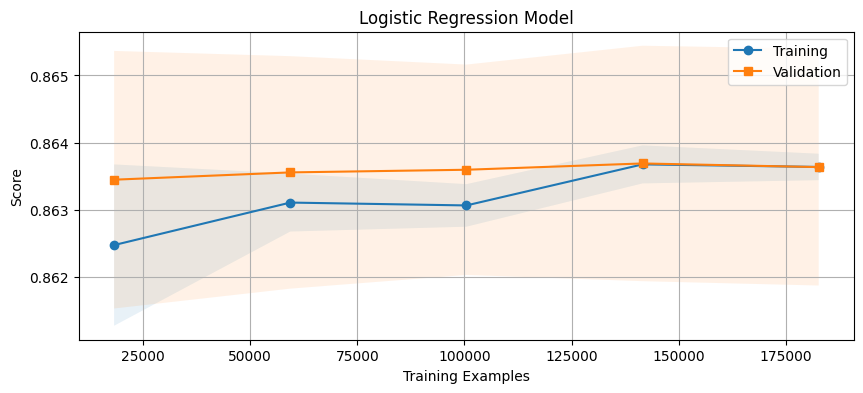

In [32]:
def graph_learning_curve(model, X_train, y_train, splitter, title="N/A"):
    fig, ax = plt.subplots(figsize=(10, 4))
    
    train_sizes, train_scores, test_scores = model_selection.learning_curve(model, X_train, y_train, cv=splitter)
    
    # Compute means and std to reflect the stability of the models
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax.set_title('{} Model'.format(title))
    ax.plot(train_sizes, train_scores_mean, 'o-', label='Training')
    ax.plot(train_sizes, test_scores_mean, 's-', label='Validation')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.grid()
    ax.legend()
    
    plt.show()

graph_learning_curve(model, X_train, y_train, splitter, "Logistic Regression")

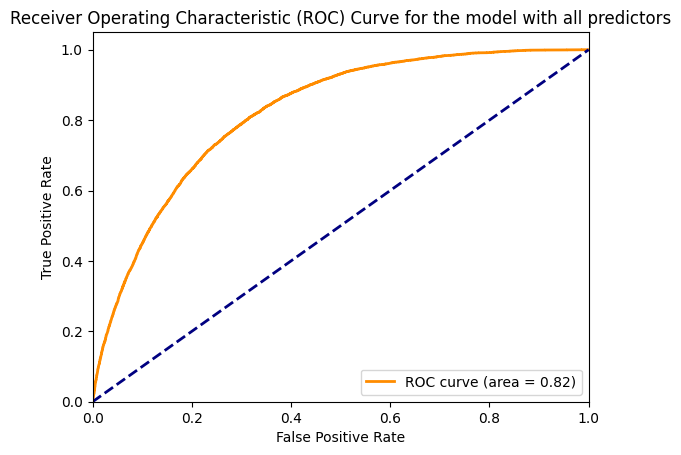

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

predicted_probabilities = model.predict_proba(X_test)[:, 1]
true_labels = y_test
auc_score_full_model = roc_auc_score(true_labels, predicted_probabilities)

def graph_auc_curve_log_reg(model, predicted_probabilities, true_labels, title="all predictors"):
    # calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    # calculate the roc_auc_score
    auc_score = roc_auc_score(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve for the model with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_log_reg(model, predicted_probabilities, true_labels)

# Now let's find out which one is most useful predictor

In [10]:
def evaluate_predictor_importance(model, X_train, X_test, y_train, y_test, metric_func, drop_index):
    # Drop one predictor
    X_train_drop = np.delete(X_train, drop_index, axis=1)
    X_test_drop = np.delete(X_test, drop_index, axis=1)
    
    # Retrain the model without the dropped predictor
    model.fit(X_train_drop, y_train)
    
    # Calculate evaluation metric after dropping the predictor
    drop_preds = model.predict_proba(X_test_drop)[:, 1]
    drop_metric = metric_func(y_test, drop_preds)
    
    # Return the change in the evaluation metric
    return drop_metric 

# Iterate through each predictor
auc_changes = []
for i in range(X_train.shape[1]):
    # Evaluate predictor importance
    auc_change = evaluate_predictor_importance(model, X_train, X_test, y_train, y_test, roc_auc_score, i)
    auc_changes.append(auc_change)

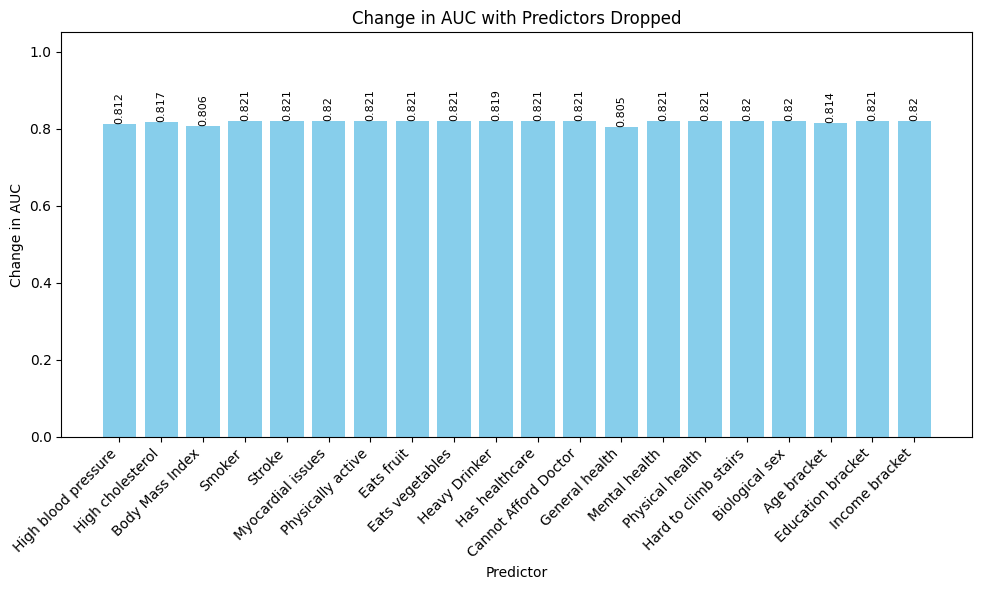

The most significant predictor is: General health
The drop in the model's performance is:  0.01585844970860062


In [11]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, auc_changes, color='skyblue')

# Add text annotations
for bar, auc_change in zip(bars, auc_changes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{auc_change:.3g}', 
             ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Predictor')
plt.ylabel('Change in AUC')
plt.title('Change in AUC with Predictors Dropped')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim([0.0, 1.05])
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

min_index = np.argmin(auc_changes)
performance_drop = auc_score_full_model - auc_changes[min_index]
print("The most significant predictor is:", column_names[min_index])
print("The drop in the model's performance is: ", performance_drop)

# Question 2: Building an SVM and evaluating the performance of the model.

Initial AUC: 0.5314609773465011
Model CV score =  0.8633169911539105
Test set score: 0.86


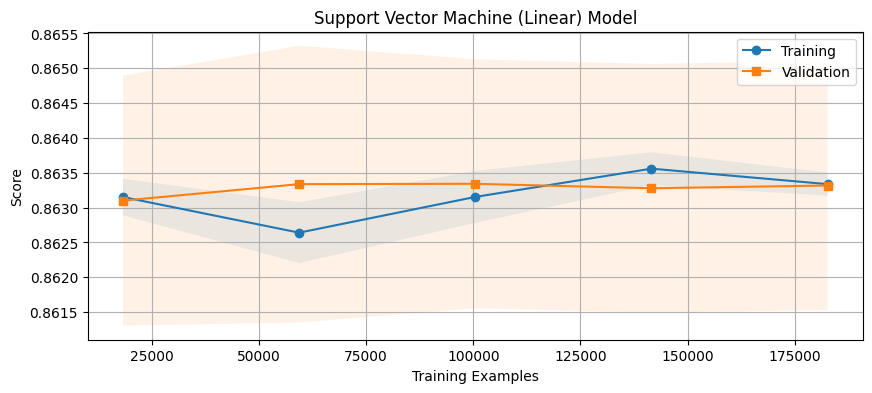

In [57]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

# Train LinearSVC
svm = LinearSVC(dual=False)
svm.fit(X_train, y_train)

# Calculate initial AUC
initial_auc = roc_auc_score(y_test, svm.predict(X_test))
print("Initial AUC:", initial_auc)


# Compute cross-validation scores.
cv_scores = model_selection.cross_val_score(svm, X_train, y_train, cv = splitter)

print("Model CV score = ", np.mean(cv_scores))
print("Test set score: {:.2f}".format(svm.score(X_test, y_test)))

graph_learning_curve(svm, X_train, y_train, splitter, "Support Vector Machine (Linear)")

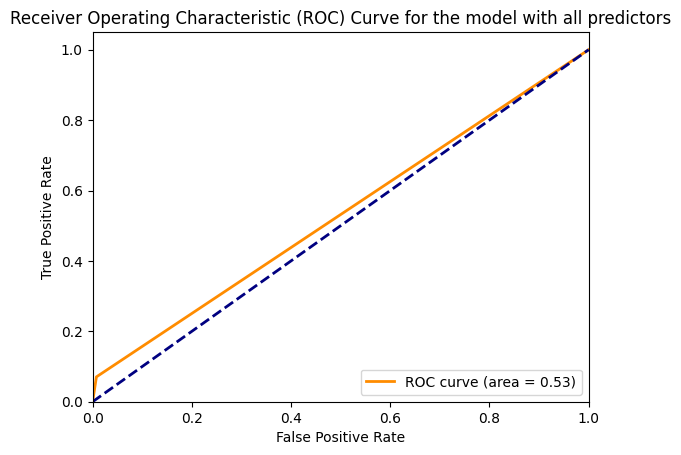

In [17]:
predicted_probabilities = svm.predict(X_test)
true_labels = y_test
auc_score_full_model = roc_auc_score(true_labels, predicted_probabilities)

def graph_auc_curve_log_reg(model, predicted_probabilities, true_labels, title="all predictors"):
    # calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    # calculate the roc_auc_score
    auc_score = roc_auc_score(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve for the model with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_log_reg(svm, predicted_probabilities, true_labels)

In [13]:
auc_changes = []
for i in range(X.shape[1]):
    X_train_drop = np.delete(X_train, i, axis=1)
    X_test_drop = np.delete(X_test, i, axis=1)
    svm = LinearSVC(dual=False)
    # Retrain SVM model
    svm.fit(X_train_drop, y_train)
    auc_drop = roc_auc_score(y_test, svm.predict(X_test_drop))
    auc_changes.append(auc_drop)

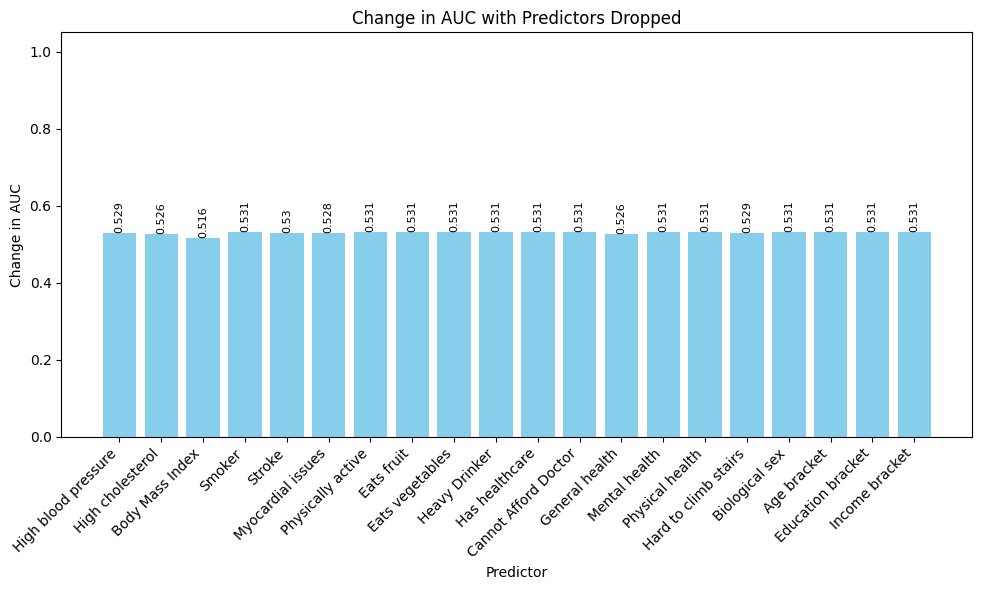

The most significant predictor is: Body Mass Index
The drop in the model's performance is:  0.015371866003117907


In [14]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, auc_changes, color='skyblue')

# Add text annotations
for bar, auc_change in zip(bars, auc_changes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{auc_change:.3g}', 
             ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Predictor')
plt.ylabel('Change in AUC')
plt.title('Change in AUC with Predictors Dropped')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim([0.0, 1.05])
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

min_index = np.argmin(auc_changes)
performance_drop = initial_auc - auc_changes[min_index]
print("The most significant predictor is:", column_names[min_index])
print("The drop in the model's performance is: ", performance_drop)

# Question 3: Use a single, individual decision tree

 0.5950286384181279


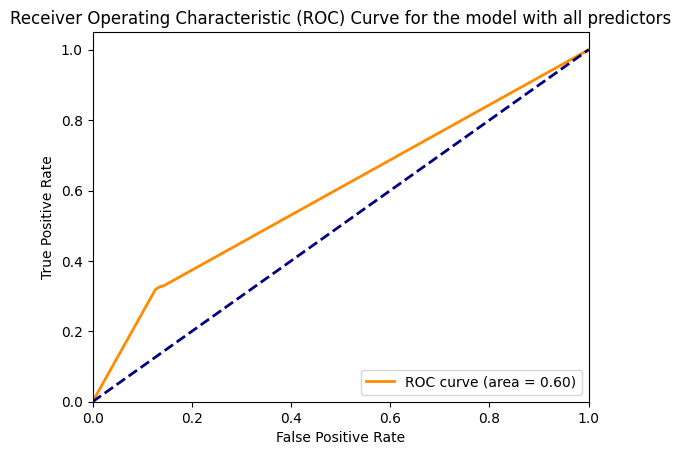

Best predictor index: 2
AUC drop: 0.5818026023929124


In [53]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model on the training set
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Calculate the baseline AUC score
initial_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("", initial_auc)

predicted_probabilities = clf.predict_proba(X_test)[:, 1]
true_labels = y_test
auc_score_full_model = roc_auc_score(true_labels, predicted_probabilities)

graph_auc_curve_log_reg(svm, predicted_probabilities, true_labels)

# Iterate through each predictor
auc_changes = []
for i in range(X.shape[1]):
    # Remove one predictor
    X_train_reduced = np.delete(X_train, i, axis=1)
    X_test_reduced = np.delete(X_test, i, axis=1)
    
    # Retrain the model on the reduced dataset
    clf.fit(X_train_reduced, y_train)
    
    # Calculate the AUC score after removing the predictor
    auc = roc_auc_score(y_test, clf.predict_proba(X_test_reduced)[:, 1])
    
    # Compute the difference between baseline AUC and AUC after removing the predictor
    # auc_diff = initial_auc - auc
    auc_changes.append(auc)

# Find the index of the predictor with the largest drop in AUC
best_predictor_index = np.argmin(auc_changes)
best_auc_drop = auc_changes[best_predictor_index]

print("Best predictor index:", best_predictor_index)
print("AUC drop:", best_auc_drop)

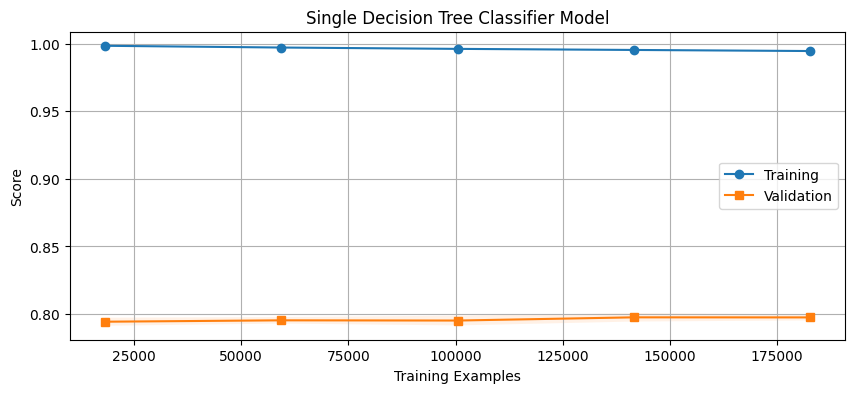

In [35]:
graph_learning_curve(clf, X_train, y_train, splitter, "Single Decision Tree Classifier")

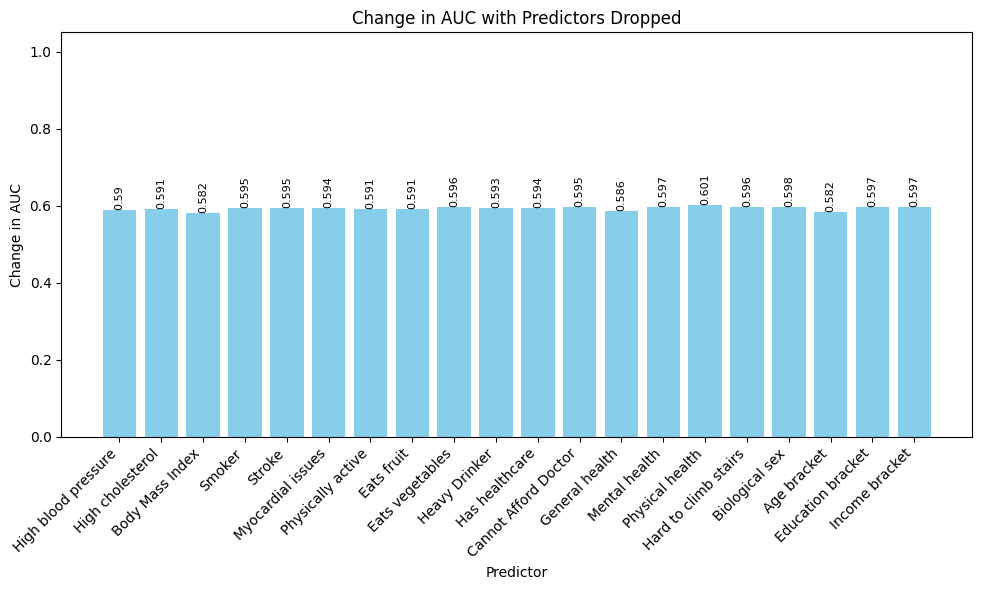

The most significant predictor is: Body Mass Index
The drop in the model's performance is:  0.013226036025215548


In [21]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, auc_changes, color='skyblue')

# Add text annotations
for bar, auc_change in zip(bars, auc_changes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{auc_change:.3g}', 
             ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Predictor')
plt.ylabel('Change in AUC')
plt.title('Change in AUC with Predictors Dropped')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim([0.0, 1.05])
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

min_index = np.argmin(auc_changes)
performance_drop = initial_auc - auc_changes[min_index]
print("The most significant predictor is:", column_names[min_index])
print("The drop in the model's performance is: ", performance_drop)

# Question 4: Random forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model on the training set
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

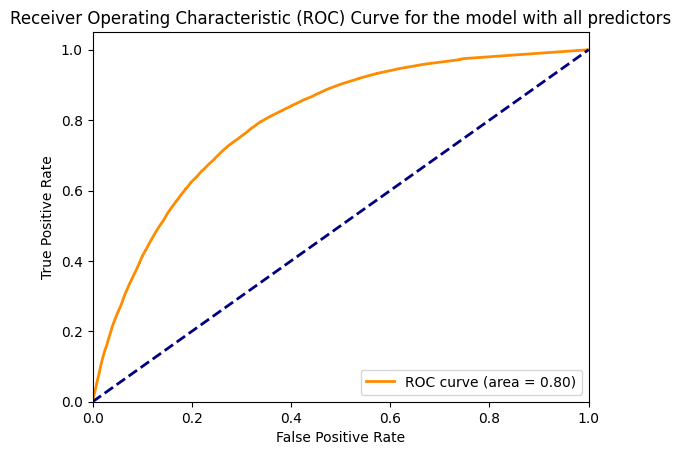

In [55]:
# Calculate the baseline AUC score
baseline_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

predicted_probabilities = rf.predict_proba(X_test)[:, 1]
true_labels = y_test

graph_auc_curve_log_reg(rf, predicted_probabilities, true_labels)

In [56]:
# Iterate through each predictor
auc_diffs = []
for i in range(X.shape[1]):
    # Remove one predictor
    X_train_reduced = np.delete(X_train, i, axis=1)
    X_test_reduced = np.delete(X_test, i, axis=1)
    
    # Retrain the model on the reduced dataset
    rf.fit(X_train_reduced, y_train)
    
    # Calculate the AUC score after removing the predictor
    auc = roc_auc_score(y_test, rf.predict_proba(X_test_reduced)[:, 1])
    
    # Compute the difference between baseline AUC and AUC after removing the predictor
    auc_diff = baseline_auc - auc
    auc_diffs.append(auc_diff)

# Find the index of the predictor with the largest drop in AUC
best_predictor_index = np.argmax(auc_diffs)
best_auc_drop = auc_diffs[best_predictor_index]

print("Best predictor index:", best_predictor_index)
print("AUC drop:", best_auc_drop)

Best predictor index: 2
AUC drop: 0.027986647566588307


In [24]:
print(baseline_auc)

0.7963058121255159


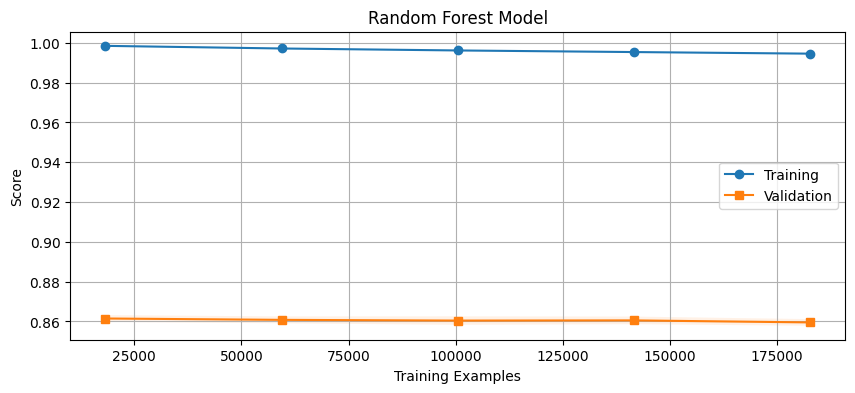

In [36]:
graph_learning_curve(rf, X_train, y_train, splitter, "Random Forest")

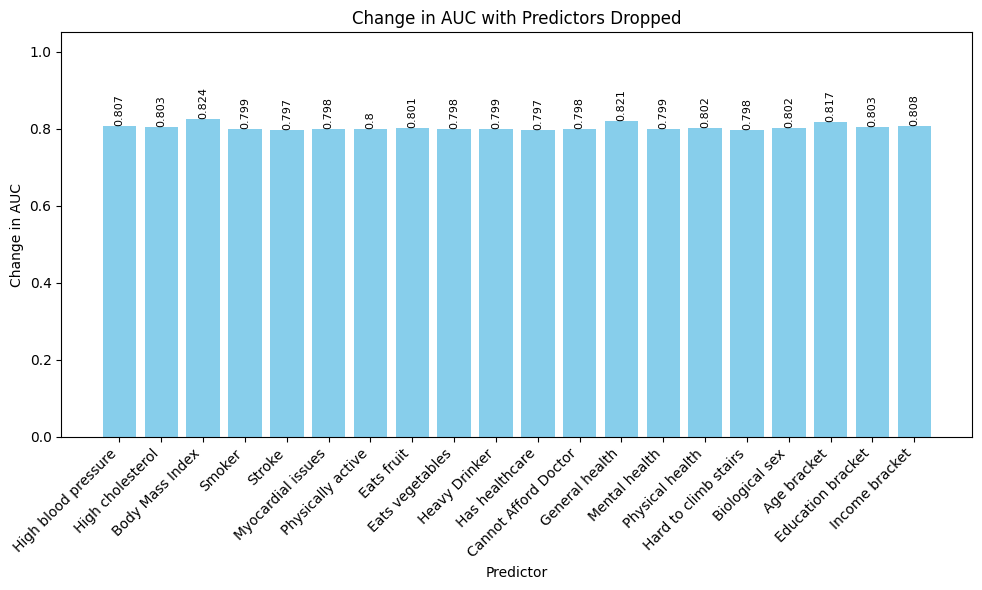

The most significant predictor is: Stroke
The drop in the model's performance is:  0.027986647566588307


In [27]:
auc_changes = []

for i in range(len(auc_diffs)):
    auc_changes.append(baseline_auc + auc_diffs[i])
    
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, auc_changes, color='skyblue')

# Add text annotations
for bar, auc_change in zip(bars, auc_changes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{auc_change:.3g}', 
             ha='center', va='bottom', fontsize=8, color='black', rotation=90)

plt.xlabel('Predictor')
plt.ylabel('Change in AUC')
plt.title('Change in AUC with Predictors Dropped')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim([0.0, 1.05])
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

min_index = np.argmin(auc_changes)
# performance_drop = baseline_auc - auc_changes[min_index]
print("The most significant predictor is:", column_names[min_index])
print("The drop in the model's performance is: ", best_auc_drop)

# Question 5: AdaBoostClassifier

In [28]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier(
    # n_estimators is the number of trees
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=2000, learning_rate=1
)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=2000)

In [29]:
preds = bdt.predict(X_test)
print(np.sum(preds == y_test)/len(preds))

0.8649873856827499


In [30]:
roc_auc_score(y_test, preds)

0.5805184527774837

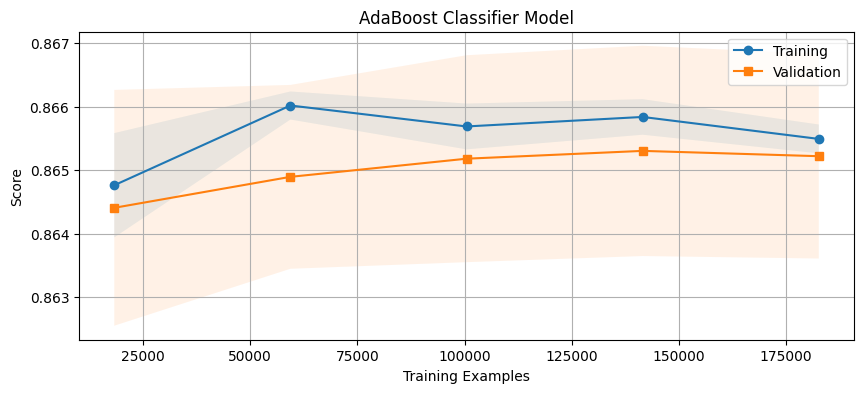

In [38]:
graph_learning_curve(bdt, X_train, y_train, splitter, "AdaBoost Classifier")

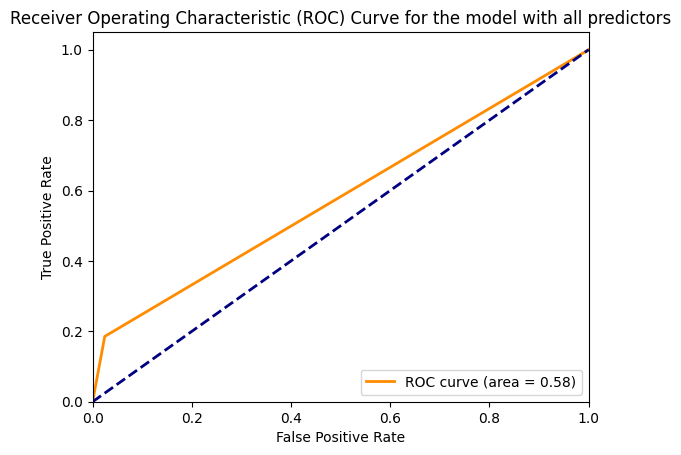

In [31]:
auc_score_full_model = roc_auc_score(y_test, preds)

def graph_auc_curve_log_reg(model, predicted_probabilities, true_labels, title="all predictors"):
    # calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
    # calculate the roc_auc_score
    auc_score = roc_auc_score(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve for the model with {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

graph_auc_curve_log_reg(bdt, preds, y_test)